This notebook illustrates methods to fill missing data for a time series using Facebook Prophet. This is an optional bonus notebook for those familiar with Facebook Prophet API. A detailed explanation of Facebook Prophet is out of scope for this course.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')

# Load dataset

In [2]:
df = pd.read_csv('../Datasets/example_retail_sales_with_missing_data.csv', parse_dates=['ds'], index_col=['ds'])

In [3]:
df.head()

,y
ds,
1992-01-01,146376.0
1992-02-01,147079.0
1992-03-01,159336.0
1992-04-01,163669.0
1992-05-01,170068.0


# Check for missing data

We check for missing data in the target and quantify how many missing values there are.

In [4]:
n_missing = df['y'].isnull().sum()

print(f"Number of datapoints missing: {n_missing}")
print(f"Proportion of dataset missing: {n_missing/len(df):.2%}")

Number of datapoints missing: 33
Proportion of dataset missing: 20.62%


We plot the time series to see where the data is missing.

<AxesSubplot:xlabel='ds'>

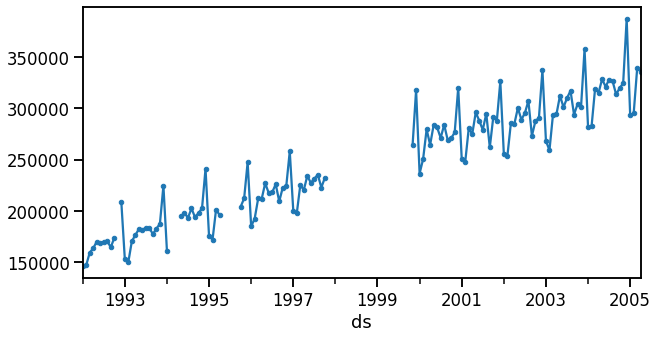

In [5]:
df.plot(marker='.', figsize=[10, 5], legend=None)


# Seasonal decomposition and interpolation

These methods involve estimating the seasonal component of a time series. This is then subtracted from the original time series to provide a de-seasoned time series. Any of the prior interpolation methods can then be used on the de-seasoned time series and the seasonal component can be added back to the de-seasoned time series. 

There are many different methods to decompose a time series into seasonal and other components. We shall use Facebook Prophet below.

# Extracting seasonality using Facebook Prophet


We demonstrate here how Facebook Prophet can also be used to extract the seasonal component of a time series and used to impute missing data.

In [6]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [7]:
# Prophet requires a dataframe with columns named `ds` and `y`
df_ = df.reset_index()
df_.head()

,ds,y
0,1992-01-01,146376.0
1,1992-02-01,147079.0
2,1992-03-01,159336.0
3,1992-04-01,163669.0
4,1992-05-01,170068.0


In [8]:
model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True).fit(df_)
res = model.predict(df_)
res.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,163037.459740,130726.727396,142534.388005,163037.459740,163037.459740,-26775.256883,-26775.256883,-26775.256883,-26775.256883,-26775.256883,-26775.256883,0.0,0.0,0.0,136262.202857
1,1992-02-01,164079.262116,133785.245823,144806.766767,164079.262116,164079.262116,-24831.007799,-24831.007799,-24831.007799,-24831.007799,-24831.007799,-24831.007799,0.0,0.0,0.0,139248.254316
2,1992-03-01,165053.851434,160467.264356,172576.216281,165053.851434,165053.851434,1385.986521,1385.986521,1385.986521,1385.986521,1385.986521,1385.986521,0.0,0.0,0.0,166439.837955
3,1992-04-01,166095.653809,157658.007253,168705.399583,166095.653809,166095.653809,-2915.754962,-2915.754962,-2915.754962,-2915.754962,-2915.754962,-2915.754962,0.0,0.0,0.0,163179.898848
4,1992-05-01,167103.849656,169832.473110,181473.825449,167103.849656,167103.849656,8429.443240,8429.443240,8429.443240,8429.443240,8429.443240,8429.443240,0.0,0.0,0.0,175533.292897


We can extract the seasonal component from the `yearly` column.

We now plot the decomposition to inspect that it is reasonable.

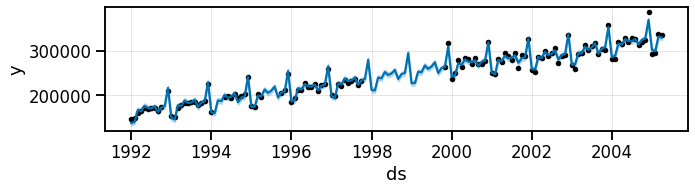

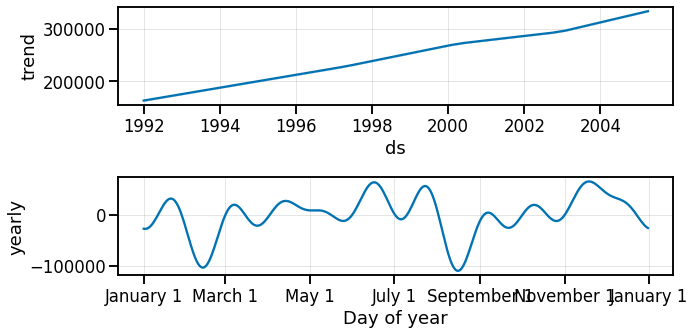

In [9]:
model.plot(res, figsize=[10, 3])
model.plot_components(res, figsize=[10, 5]);

In [10]:
# Extract seasonal component
seasonal_component = res.set_index('ds')['yearly']
seasonal_component.head()

ds
1992-01-01   -26775.256883
1992-02-01   -24831.007799
1992-03-01     1385.986521
1992-04-01    -2915.754962
1992-05-01     8429.443240
Name: yearly, dtype: float64

<AxesSubplot:xlabel='ds'>

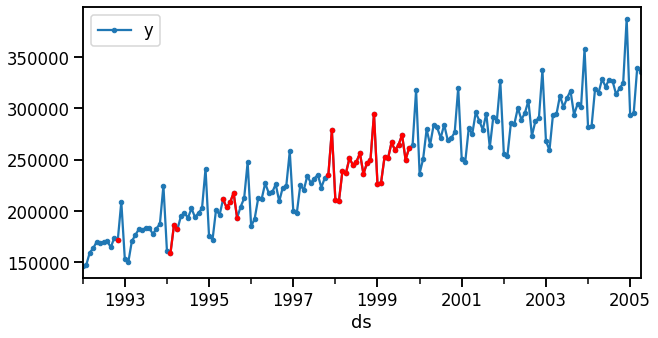

In [11]:
# De-seasonlise original data
df_deseasonalised = df['y'] - seasonal_component

# Perform linear interpolation on de-seasonalised data
df_deseasonalised_imputed = df_deseasonalised.interpolate(method='linear')

# Add seasonal component back to get the final imputed time series
df_imputed = df_deseasonalised_imputed + seasonal_component

# Plot the imputed time series
df_imputed = df_imputed.to_frame().rename(columns={0:'y'})
ax = df_imputed.plot(linestyle='-', marker='.', figsize=[10, 5])
df_imputed[df.isnull()].plot(ax=ax, legend=None, marker='.', color='r')